In [21]:
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Key parameters for test
Nan_rate_set = 0.05
Time_interval = 2

In [22]:
# 1 Speical Case ni Muke
# 1.1 Read TS Cube

def read_geotiff(file_path):
    with rasterio.open(file_path) as src:
        image = src.read()
        transform = src.transform
        crs = src.crs
        band_names = src.descriptions
    return image, transform, crs, band_names

image, transform, crs, band_names = read_geotiff('NDVI_CLM.tif')

# Read time series label
def read_csv_to_list(file_path):
    df = pd.read_csv(file_path, header=None)
    return df[1].tolist()

time_label = read_csv_to_list('Date.csv')
# Drop header
time_label = time_label[1:]
# Extract time and replace underscore with dash
time_label = [s.split('_NDVI')[0].replace('_', '-') for s in time_label]

In [23]:
# 1.2 Get TS of each pixel
# Get Dimension
num_bands, height, width = image.shape

# Initialize a list
result = []
ts=[] # with nan

# Loop through each pixel
for i in range(height):
    for j in range(width):
        # Get pixel values
        pixel_values = image[:, i, j]
        nan_ratio = np.isnan(pixel_values).sum() / len(pixel_values)
        if nan_ratio < Nan_rate_set:
        #if not np.all(np.isnan(pixel_values)):
        # Append to list
            result.append([i, j,pixel_values])
            ts.append(pixel_values)

ts = pd.DataFrame(result, columns=["height", "width", "value"])

In [24]:
# 1.3 TS Interpolation （De-nan）

for i in range(len(ts['value'])):
    ts['value'][i] = pd.Series(ts['value'][i])
    # Fill nan with linear interpolation
    ts['value'][i] = ts['value'][i].interpolate(method='linear')

# Drop NaN values row
nan_indices = [i for i, x in enumerate(ts['value']) if np.isnan(x).any()]
ts = ts.drop(nan_indices)


ts['id'] = range(0, len(ts))

# Visualise the time series first
# sequence=ts['value'][1]
# plt.figure(figsize=(10, 6))
# plt.plot(sequence, color='red', linestyle='-', label='Interpolated')
# plt.title('NDVI Time Series Plot')
# plt.xlabel('Time')
# plt.ylabel('NDVI')
# plt.xticks(np.arange(0, len(sequence), 100), time_label[::100])
# plt.legend()
# plt.show()

/var/folders/xc/f4r4d4jn72jc7khb57dk5lbm0000gn/T/ipykernel_83187/3823242018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['value'][i] = pd.Series(ts['value'][i])
/var/folders/xc/f4r4d4jn72jc7khb57dk5lbm0000gn/T/ipykernel_83187/3823242018.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ts['value'][i] = ts['value'][i].interpolate(method='linear')
/var/folders/xc/f4r4d4jn72jc7khb57dk5lbm0000gn/T/ipykernel_83187/3823242018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guid

In [28]:
image.shape

(506, 733, 776)

In [30]:
# 2.1 Standard TS Format

# Convert pandas DataFrame
data = pd.DataFrame(ts['value'].tolist())
data['id'] = range(0, len(data))
# Transpose the DataFrame
data_transposed = data.set_index('id').T
# Add Date
time = pd.to_datetime(time_label)
data_transposed['date'] = time

# Select every fourth row
data_transposed_half = data_transposed.iloc[::Time_interval]
# Melt the DataFrame
data_melted = data_transposed_half.melt(id_vars=['date'])

print(data_melted)

             date    id     value
0      2005-01-01     0  0.424281
1      2005-01-17     0  0.360964
2      2005-02-02     0  0.435974
3      2005-02-18     0  0.481509
4      2005-03-06     0  0.454996
...           ...   ...       ...
375447 2015-10-16  1483  0.357742
375448 2015-11-01  1483  0.478983
375449 2015-11-17  1483  0.391249
375450 2015-12-03  1483  0.378531
375451 2015-12-19  1483  0.318976

[375452 rows x 3 columns]


Init 1
0.078 --> 0.075 --> 0.073 --> 0.073 --> 
Init 2
0.090 --> 0.079 --> 0.075 --> 0.073 --> 0.074 --> 
Init 3
0.080 --> 0.071 --> 0.072 --> 
Init 4
0.081 --> 0.079 --> 0.080 --> 
Init 5
0.083 --> 0.077 --> 0.074 --> 0.073 --> 0.074 --> 
Init 1
0.077 --> 0.066 --> 0.061 --> 0.062 --> 
Init 2
0.063 --> 0.063 --> 0.064 --> 
Init 3
0.070 --> 0.068 --> 0.070 --> 
Init 4
0.069 --> 0.067 --> 0.068 --> 
Init 5
0.064 --> 0.060 --> 0.060 --> 0.061 --> 
Init 1
0.076 --> 0.063 --> 0.058 --> 0.057 --> 0.058 --> 
Init 2
0.054 --> 0.052 --> 0.053 --> 
Init 3
0.058 --> 0.056 --> 0.056 --> 
Init 4
0.063 --> 0.058 --> 0.058 --> 0.058 --> 
Init 5
0.070 --> 0.058 --> 0.058 --> 
Init 1
0.063 --> 0.053 --> 0.052 --> 0.052 --> 
Init 2
0.054 --> 0.051 --> 0.052 --> 
Init 3
0.060 --> 0.055 --> 0.055 --> 0.056 --> 
Init 4
0.055 --> 0.054 --> 0.054 --> 0.054 --> 0.054 --> 
Init 5
0.055 --> 0.054 --> 0.055 --> 
Init 1
0.051 --> 0.050 --> 0.049 --> 0.049 --> 
Init 2
0.051 --> 0.048 --> 0.048 --> 
Init 3
0.056 -

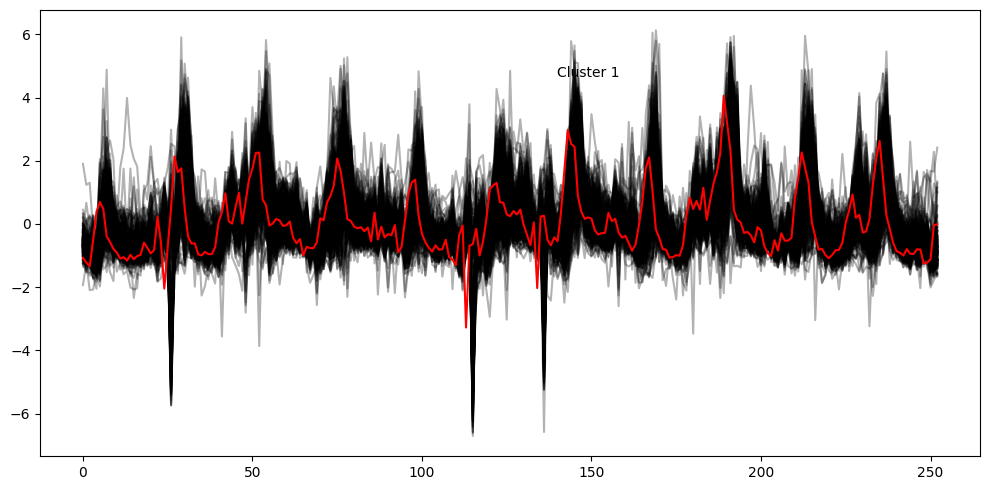

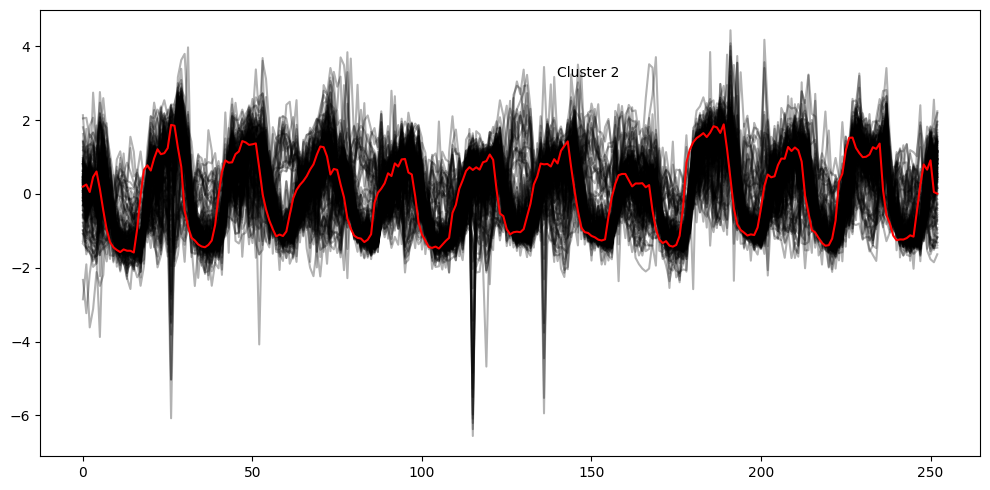

best_shape : 2


In [31]:
# 2.2  TS classification 
from tslearn.clustering import KShape
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import silhouette_score

"""
1. Data Reading and Preprocessing
2. Calculate the silhouette coefficient and obtain the optimal number of clusters k
3. Get the labels of the clusters with k clusters
4. Visualisation
"""

class Plot_Cluster_Time_Series(object):
    # class initialization
    def __init__(self,data,seed):
        self.data=data
        self.seed=seed

    def fill_na_ts(self):
        data = self.data
        df_store = data[['id']].drop_duplicates()
        max_ds = str(data['date'].max())[:10].replace('-', '')
        min_ds = str(data['date'].min())[:10].replace('-', '')
        print('min time is : {},max time is : {}'.format(min_ds, max_ds))
        time_index = pd.date_range(min_ds, max_ds, freq='D')
        time_index = pd.DataFrame(time_index)
        time_index.columns = ['ts_index']

        time_index['join_value'] = 1
        df_store['join_value'] = 1
        store_time_index = pd.merge(time_index, df_store, how='left', on='join_value')
        store_time_index.drop(columns='join_value', inplace=True)

        #data['date'] = pd.to_datetime(data['date'])
        store_time_index['ts_index'] = pd.to_datetime(store_time_index['ts_index'])
        store_time_index.rename(columns={'ts_index': 'date'}, inplace=True)
        data_full = pd.merge(store_time_index, data, how='left', on=['date', 'id'])
        data_full['value'] = data_full['value'].fillna(0)
        data_full.fillna(0, inplace=True)
        return data_full

    def read_data(self):
        """
        :return: norm dataset and time series id
        """
        #data = self.fill_na_ts() # not necessary to fill gap and replace nan with 0
        data = self.data
        multi_ts = data.sort_values(by=['id', 'date'], ascending=[1, 1])[['id', 'value']]
        int_numer = multi_ts.shape[0] // multi_ts['id'].nunique()
        #multi_ts = multi_ts.groupby('id').filter(lambda x: x['id'].count() ==int_numer)
        data_array = np.array(multi_ts[['value']]).reshape(multi_ts['id'].nunique(),multi_ts.shape[0] // multi_ts['id'].nunique())
        scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
        ts_norm = scaler.fit_transform(data_array)
        #ts_norm = data_array.reshape((data_array.shape[0], data_array.shape[1], 1))
        return ts_norm, multi_ts['id'].unique()

    def plot_elbow(self,data):
        """
        :param df:multi time series  type is np.array
        :return: elbow plot
        """
        distortions = []
        for i in range(2, 7):
            ks = KShape(n_clusters=i, n_init=5, verbose=True, random_state=self.seed)
            ks.fit(data)
            distortions.append(ks.inertia_)
        plt.plot(range(2, 7), distortions, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion Line')
        plt.show()


    def shape_score(self,data,labels,metric='dtw'):
        """
        :param df:
        :param labels:
        :param metric:
        :return:
        """
        score = silhouette_score(data,labels,metric)
        return score

    def cal_k_shape(self,data,num_cluster):
        """
        use best of cluster
        :param df: time series dataset
        :param num_cluster:
        :return:cluster label
        """
        ks = KShape(n_clusters=num_cluster, n_init=5, verbose=True, random_state=self.seed)
        y_pred = ks.fit_predict(data)
        return y_pred

    def plot_best_shape(self,data,num_cluster):
        """
        time series cluster plot
        :param df:
        :param num_cluster:
        :return:
        """
        ks = KShape(n_clusters=num_cluster, n_init=5, verbose=True, random_state=self.seed)
        y_pred = ks.fit_predict(data)
        for yi in range(num_cluster):
            plt.figure(figsize=(10, 5))
            for xx in data[y_pred == yi]:
                plt.plot(xx.ravel(), "k-", alpha=.3)
            plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
            plt.text(0.55, 0.85, 'Cluster %d' % (yi + 1),
                     transform=plt.gca().transAxes)
            plt.tight_layout()
            plt.show()

# Part of data
data_s=data_melted[data_melted['id'].isin(data_melted['id'].unique()[:500])] 
# data_s = data_melted

# Object from class
seed = 666
pcts = Plot_Cluster_Time_Series(data_s,seed)
input_df, multi_id = pcts.read_data()

# Find the best cluster number
k_shape, k_score = [], []
for i in range(2, 7):
    shape_pred = pcts.cal_k_shape(input_df,i)
    score = pcts.shape_score(input_df,shape_pred)
    k_score.append(score)
    k_shape.append(i)
dict_shape = dict(zip(k_shape, k_score))
best_shape = sorted(dict_shape.items(), key=lambda x: x[1], reverse=True)[0][0]

# Get the final cluster label
fin_label = pcts.cal_k_shape(input_df,best_shape)
fin_cluster = pd.DataFrame({"id": multi_id, "cluster_label": fin_label})
pcts.plot_best_shape(input_df,best_shape)
# pcts.plot_elbow(input_df)

print('best_shape :',best_shape)

{2: 0.19526843270161845, 3: 0.18734247992121375, 4: 0.171033463621883, 5: 0.15501471063500089, 6: 0.15168839605872397}
Init 1
0.078 --> 0.075 --> 0.073 --> 0.073 --> 
Init 2
0.090 --> 0.079 --> 0.075 --> 0.073 --> 0.074 --> 
Init 3
0.080 --> 0.071 --> 0.072 --> 
Init 4
0.081 --> 0.079 --> 0.080 --> 
Init 5
0.083 --> 0.077 --> 0.074 --> 0.073 --> 0.074 --> 
Init 1
0.077 --> 0.066 --> 0.061 --> 0.062 --> 
Init 2
0.063 --> 0.063 --> 0.064 --> 
Init 3
0.070 --> 0.068 --> 0.070 --> 
Init 4
0.069 --> 0.067 --> 0.068 --> 
Init 5
0.064 --> 0.060 --> 0.060 --> 0.061 --> 
Init 1
0.076 --> 0.063 --> 0.058 --> 0.057 --> 0.058 --> 
Init 2
0.054 --> 0.052 --> 0.053 --> 
Init 3
0.058 --> 0.056 --> 0.056 --> 
Init 4
0.063 --> 0.058 --> 0.058 --> 0.058 --> 
Init 5
0.070 --> 0.058 --> 0.058 --> 
Init 1
0.063 --> 0.053 --> 0.052 --> 0.052 --> 
Init 2
0.054 --> 0.051 --> 0.052 --> 
Init 3
0.060 --> 0.055 --> 0.055 --> 0.056 --> 
Init 4
0.055 --> 0.054 --> 0.054 --> 0.054 --> 0.054 --> 
Init 5
0.055 --> 0.

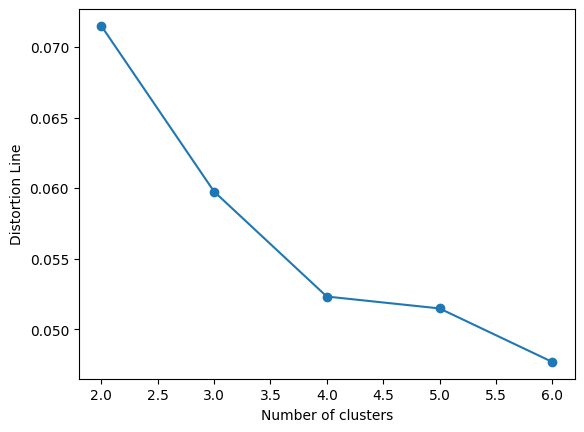

In [32]:
print(dict_shape)
pcts.plot_elbow(input_df)

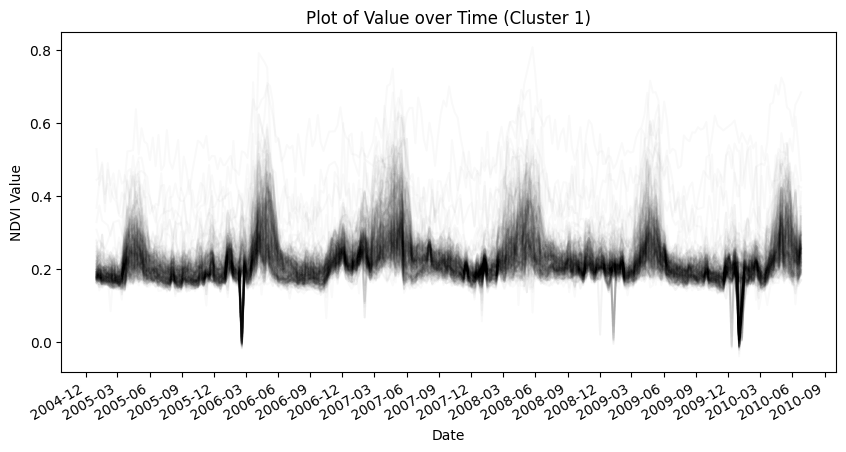

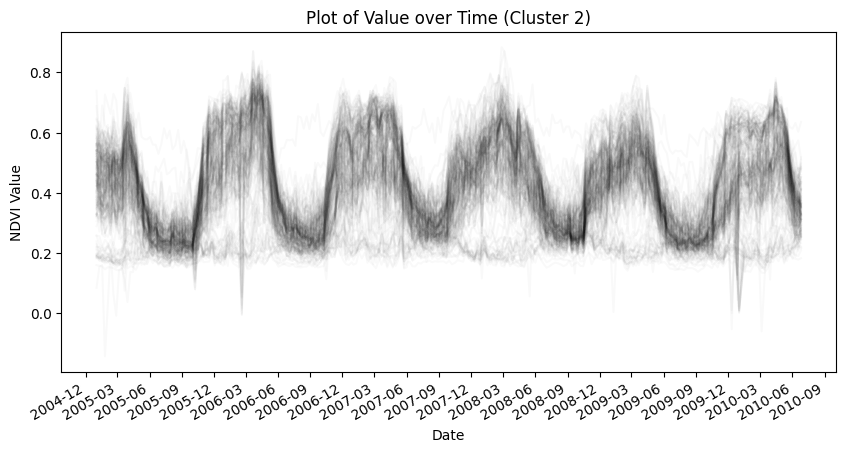

In [34]:
# 3.1  Visualisation

# Control to show half or full date interval
# Half: original data_s
# Full: data_melted
data_melted_full = data_transposed.melt(id_vars=['date'])

data_with_label = pd.merge(data_melted_full, fin_cluster, how='left', on='id')

grouped = data_with_label.groupby('cluster_label')
dwl = {}
for name, group in grouped:
    dwl[name] = group

    grouped_by_id = dwl[name].groupby('id')

    plt.figure(figsize=(10, 5))
    for name_2, group_2 in grouped_by_id:
        half_length = len(group_2) // 2  # get half length
        group_2 = group_2.iloc[:half_length]  # get half length data
        plt.plot(group_2['date'], group_2['value'], "k-", alpha=.025)

    # # Set date format
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.gcf().autofmt_xdate()  # Rotate the date lable
    
    # Add x y labels
    plt.xlabel('Date')
    plt.ylabel('NDVI Value')
    plt.title('Plot of Value over Time (Cluster %i)' % (name+1))
    
    plt.show()

In [33]:
fin_cluster.groupby('cluster_label').size()

cluster_label
0    305
1    195
dtype: int64

In [ ]:
# 3.2 Visulisation map

# Connect the cluster label to the original data (height, width index)
data_with_xy = pd.merge(ts, fin_cluster, how='left', on='id')
data_with_xy

image_class = np.full((height, width),np.nan)
for i in range(len(data_with_xy)):
    image_class[data_with_xy['height'][i],data_with_xy['width'][i]] = data_with_xy['cluster_label'][i]

plt.imshow(image_class)
plt.colorbar()
plt.title('Image Class')
plt.show()

In [ ]:
# 3.3 Select One Pixel

# Select the cluster 1 and Extract this part of data
grouped_by_id = dwl[1].groupby('id')
one_pixel = {}
one_pixel_index = {}
i=0
plt.figure(figsize=(10, 5))

for name_2, group_2 in grouped_by_id:
    one_pixel_index[i] = name_2
    one_pixel[name_2] = group_2
    i+=1

# Set index of the selected pixel
k=21
tsk = one_pixel[one_pixel_index[k]]
half_length = len(tsk) // 2  # get half length
#tsk = tsk.iloc[:half_length]  # get half length of data
plt.plot(tsk['date'], tsk['value'], "k-", alpha=1)

# # Set date format
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
# plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# plt.gcf().autofmt_xdate() 

# Add x,y label and title
plt.xlabel('Date')
plt.ylabel('NDVI Value')
plt.title('Plot of Value over Time on Selected Pixel of (Cluster %s)' %2)

plt.show()

In [ ]:
# 3.4 Export One pixel ts

# Select 'date' 和 'value' column
tsk_subset = tsk[['date', 'value']]

# Export as csv
tsk_subset.to_csv('time_series_one_pixel.csv', index=False)